In [1]:
#### Text classification with an RNN
#### Setup 

!pip install tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [10]:
#### Setup input pipeline

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

In [11]:
#### The dataset info includes the encoder (a tfds.features.text.SubwordTextEncoder).
encoder = info.features['text'].encoder

In [12]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [20]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [21]:
assert original_string == sample_string

In [22]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [24]:
#### Prepare the data for training
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [25]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

In [26]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

In [27]:
#### Create the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
#### Train the model

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1057s 3s/step - loss: 0.4798 - accuracy: 0.7398 - val_loss: 0.3520 - val_accuracy: 0.8302
Epoch 2/10
391/391 [==============================] - 1195s 3s/step - loss: 0.2741 - accuracy: 0.8902 - val_loss: 0.3456 - val_accuracy: 0.8208
Epoch 3/10
391/391 [==============================] - 1055s 3s/step - loss: 0.2226 - accuracy: 0.9146 - val_loss: 0.3269 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 1038s 3s/step - loss: 0.1866 - accuracy: 0.9311 - val_loss: 0.3307 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 1063s 3s/step - loss: 0.1673 - accuracy: 0.9408 - val_loss: 0.3381 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 1063s 3s/step - loss: 0.1479 - accuracy: 0.9490 - val_loss: 0.3540 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 1016s 3s/step - loss: 0.1535 - accuracy: 0.9433 - val_loss: 0.3628 - val_accuracy:

In [33]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 152s 390ms/step - loss: 0.4592 - accuracy: 0.8585
Test Loss: 0.4591636657714844
Test Accuracy: 0.8584799766540527


In [34]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [35]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [36]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.57990354]]


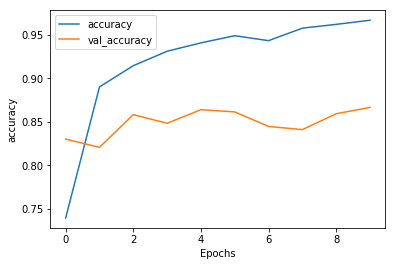

In [37]:
plot_graphs(history, 'accuracy')

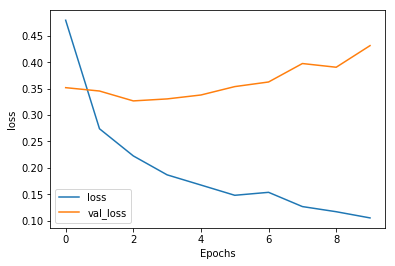

In [38]:
plot_graphs(history, 'loss')

In [ ]:
#### Stack two or more LSTM layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')